In [32]:
import numpy as np
import scipy.sparse as sparse
from os import listdir
import random
import matplotlib.pyplot as plt
from itertools import product, combinations, zip_longest
import cvxpy as cp
from collections import namedtuple

# Pull genotypes for a chromosome
m = 6
data_dir = '../split_gen_ihart'
#data_dir = '../split_gen_ihart_chip'
sample_file = '%s/chr.1.gen.samples.txt' % (data_dir)
ped_file = '../data/160826.ped'

In [33]:
# pull families with sequence data
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]

# pull families from ped file
families = dict()
sample_id_to_sex = dict()
sample_id_to_affected = dict()

with open(ped_file, 'r') as f:	
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_id_to_index and f_id in sample_id_to_index and m_id in sample_id_to_index and 'LCL' not in child_id:
            if (fam_id, m_id, f_id) not in families:
                families[(fam_id, m_id, f_id)] = [m_id, f_id]
                sample_id_to_sex[m_id] = '2'
                sample_id_to_sex[f_id] = '1'
            families[(fam_id, m_id, f_id)].append(child_id)
            sample_id_to_sex[child_id] = pieces[4]
            sample_id_to_affected[child_id] = pieces[5]
            
families_of_this_size = [(fkey, inds) for fkey, inds in families.items() if len(inds) == m]
print('families of size %d: %d' % (m, len(families_of_this_size)))



families of size 6: 57


# Look at one family

In [34]:
lcl_wb_inds = set(['AU1043304', 'AU2911309', 'AU1860301', 'AU3154301', 'AU3053301', 'AU3646301', 'AU3846302', 'AU3702307', 'AU3761302', 'AU3913302', 'AU3713302', 'AU3051303', 'AU3839303', 'AU4032306', 'AU2410302', 'AU1308303', 'AU4235303'])
families_of_this_size_with_lcl_wb_ind = [(fkey, inds) for fkey, inds in families_of_this_size if len(set(inds) & lcl_wb_inds) > 0]
print(len(families_of_this_size_with_lcl_wb_ind))


4


In [35]:
# WGS family: ('AU1163', 'AU1163202', 'AU1163201') ['AU1163202', 'AU1163201', 'AU1163302', 'AU1163303', 'AU1163304', 'AU1163305'] [1523, 1528, 1524, 1526, 1525, 1527]

# pick family
famkey, inds = random.choice(families_of_this_size_with_lcl_wb_ind)
lcl_wb_ind = list(set(inds) & lcl_wb_inds)[0]


indices = [sample_id_to_index[i] for i in inds] + [sample_id_to_index[lcl_wb_ind + '_LCL']]
print(famkey, inds, indices)



('AU3839', 'AU3839202', 'AU3839201') ['AU3839202', 'AU3839201', 'AU3839301', 'AU3839302', 'AU3839303', 'AU3839304'] [4442, 4441, 4443, 4444, 4445, 4447, 4446]


In [36]:
print([sample_id_to_sex[x] for x in inds])

['2', '1', '2', '2', '1', '1']


In [37]:
chroms = [str(x) for x in range(1, 23)]
all_gens = [None for _ in chroms]
all_positions = [None for _ in chroms]
num_calls = [None for _ in chroms]
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    try:
        gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

        # pull snp positions
        pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
        snp_positions = pos_data[:, 1]
        is_snp = pos_data[:, 2].astype(bool)

        # Pull data together
        A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

        # filter out snps
        A = A[:, is_snp].A
        snp_positions = snp_positions[is_snp]
        num_calls[i] = snp_positions.shape[0]

        # don't need low coverage flag on missing values
        A[A<0] = 3

        # remove positions where whole family is missing or whole family is homref
        ok_indices = np.any(A>0, axis=0)
        A = A[:, ok_indices]
        snp_positions = snp_positions[ok_indices]

        print(A.shape)
        all_gens[i] = A
        all_positions[i] = snp_positions
    except Exception as e:
        print('Error')
        print(e)

1 (7, 454963)
2 Error
Bad CRC-32 for file 'indices.npy'
3 (7, 361826)
4 (7, 404247)
5 (7, 332946)
6 (7, 353852)
7 (7, 344242)
8 (7, 290792)
9 (7, 305873)
10 (7, 283747)
11 (7, 270072)
12 (7, 251907)
13 Error
Bad CRC-32 for file 'indices.npy'
14 (7, 185694)
15 (7, 180687)
16 (7, 199158)
17 (7, 159569)
18 (7, 149144)
19 (7, 124996)
20 (7, 128083)
21 (7, 107415)
22 (7, 87673)


In [39]:
i, chrom = 12, '13'

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_calls[i] = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = 3

# remove positions where whole family is missing or whole family is homref
ok_indices = np.any(A>0, axis=0)
A = A[:, ok_indices]
snp_positions = snp_positions[ok_indices]

print(A.shape)
all_gens[i] = A
all_positions[i] = snp_positions

(7, 195058)


# Poisson Regression

In [40]:
chrom_lengths = {
	'1': 225934550,
	'2': 238204522,
	'3': 194797140,
	'4': 188042934,
	'5': 177695260,
	'6': 167395067,
	'7': 155536559,
	'8': 142964911,
	'9': 120626573,
	'10': 131314747,
	'11': 131169619,
	'12': 130481395,
	'13': 95589878,
	'14': 88289540,
	'15': 81694769,
	'16': 78884753,
	'17': 78129607,
	'18': 74661510,
	'19': 56060841,
	'20': 59505520,
	'21': 35134224,
	'22': 34894566,
	'X': 151100560,
	'Y': 25653566
}


In [41]:
possible_genotypes_parents = [0, 1, 2]
possible_genotypes_children = [0, 1, 2]
possible_genotypes_famgen = [possible_genotypes_parents, possible_genotypes_parents] + [possible_genotypes_children]*(m-2)
all_famgens = list(product(*possible_genotypes_famgen))
#all_famgens = list(product(*[[0, 1, 2]]*m))
famgen_to_index = dict([(x, i) for i, x in enumerate(all_famgens)])
print('famgens', len(famgen_to_index))

famgens 729


In [42]:
mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2)
}

is_mendelian = np.ones(tuple(len(x) for x in possible_genotypes_famgen), dtype=bool)
for famgen in all_famgens:
    is_mend = True
    for j in range(2, m):
        if tuple([famgen[x] for x in [0, 1, j]]) not in mendelian_trios:
            is_mend = False
    is_mendelian[famgen] = is_mend
print('Mendelian', np.sum(is_mendelian), 'Nonmendelian', np.sum(~is_mendelian))
print(is_mendelian.shape)



Mendelian 149 Nonmendelian 580
(3, 3, 3, 3, 3, 3)


In [43]:
from collections import defaultdict

nonmendelian_famgens = list(zip(*np.where(~is_mendelian)))
mendelian_famgens = list(zip(*np.where(is_mendelian)))

nm_famgen_to_index = dict([(x, i) for i, x in enumerate(nonmendelian_famgens)])

transition_to_fg_pairs = defaultdict(list)
for nmfg in nonmendelian_famgens:
    for j in range(m):
        for i in range(len(possible_genotypes_famgen[j])):
            mfg = tuple(i if k==j else nmfg[k] for k in range(m))
            if is_mendelian[mfg]:
                new_transition = tuple([(j, b, a) for j, (a, b) in enumerate(zip(nmfg, mfg)) if a != b])
                transition_to_fg_pairs[new_transition].append((nmfg, mfg))
        
all_transitions = sorted(transition_to_fg_pairs.keys())
print('transitions', len(all_transitions))
is_one_step = np.asarray([len(t)==1 for t in all_transitions])
print('one step', np.sum(is_one_step))
transition_to_index = dict([(x, i) for i, x in enumerate(all_transitions)])

transitions 32
one step 32


In [44]:
print(all_transitions)

[((0, 0, 2),), ((0, 1, 0),), ((0, 1, 2),), ((0, 2, 0),), ((1, 0, 2),), ((1, 1, 0),), ((1, 1, 2),), ((1, 2, 0),), ((2, 0, 1),), ((2, 0, 2),), ((2, 1, 0),), ((2, 1, 2),), ((2, 2, 0),), ((2, 2, 1),), ((3, 0, 1),), ((3, 0, 2),), ((3, 1, 0),), ((3, 1, 2),), ((3, 2, 0),), ((3, 2, 1),), ((4, 0, 1),), ((4, 0, 2),), ((4, 1, 0),), ((4, 1, 2),), ((4, 2, 0),), ((4, 2, 1),), ((5, 0, 1),), ((5, 0, 2),), ((5, 1, 0),), ((5, 1, 2),), ((5, 2, 0),), ((5, 2, 1),)]


In [45]:
def build_genome_X_and_y(chroms, family_genotypes_for_chroms, num_calls):
    genotype_to_counts = np.zeros(tuple(len(x) for x in possible_genotypes_famgen), dtype=int)
    
    for chrom, family_genotypes_for_chrom, nc in zip(chroms, family_genotypes_for_chroms, num_calls):
        family_genotypes_for_chrom[family_genotypes_for_chrom==3] = 0
        unique_gens, counts = np.unique(family_genotypes_for_chrom, return_counts=True, axis=1)

        # fill in genotype_to_counts
        ref_counts = 0
        for g, c in zip(unique_gens.T, counts):
            if tuple(g) in famgen_to_index:
                genotype_to_counts[tuple(g)] += c
                
                if tuple(g) == tuple([0]*m):
                    ref_counts = c

        genotype_to_counts[tuple([0]*m)] += (nc - family_genotypes_for_chrom.shape[1]) + ref_counts

    # form X
    X = np.zeros((len(nonmendelian_famgens), len(all_transitions)))
    
    for trans, fg_pairs in transition_to_fg_pairs.items():
        trans_index = transition_to_index[trans]
        for famgen, neighbor in fg_pairs: # nmfg, mfg
            famgen_index = nm_famgen_to_index[famgen]
            
            if genotype_to_counts[neighbor]>0:
                slice_def = tuple(slice(None, None, None) if a==b else b for a, b in zip(famgen, neighbor))
                X[famgen_index, trans_index] = genotype_to_counts[neighbor]/np.sum((genotype_to_counts*is_mendelian)[slice_def])
                
    y = np.asarray([genotype_to_counts[x] for x in nonmendelian_famgens])

    print('zeros rows:', np.sum(np.sum(X, axis=1)==0), 'cols:', np.sum(np.sum(X, axis=0)==0))
    indices = np.where(np.sum(X, axis=1) != 0)[0]
    unused_famgens = [nonmendelian_famgens[i] for i in range(len(nonmendelian_famgens)) if i not in indices]
    X = X[indices, :]
    y = y[indices]
    nm = [nonmendelian_famgens[i] for i in indices]
    
    
    return X, y, nm, genotype_to_counts, unused_famgens
    

In [46]:
def estimate_family_error(X, y, all_transitions, tie_inds=False):
    
    old_trans_index_to_new_trans_index = dict()
    
    new_transitions = []
    
    if tie_inds:
        for s1, e1 in set([t[0][1:] for t in all_transitions if len(t)==1]):
            ts = [i for i, t in enumerate(all_transitions) if len(t) == 1 and t[0][1] == s1 and t[0][2] == e1]
            for t in ts:
                old_trans_index_to_new_trans_index[t] = len(new_transitions)  
            new_transitions.append((s1, e1))
    else: 
        for j, s, e in set([(t[0][0], t[0][1], t[0][2]) for t in all_transitions if len(t)==1]):
            ts = [i for i, t in enumerate(all_transitions) if len(t) == 1 and t[0][0] == j and t[0][1] == s and t[0][2] == e]
            for t in ts:
                old_trans_index_to_new_trans_index[t] = len(new_transitions)  
            new_transitions.append((j, s, e))
    
    
            
    newX = np.zeros((X.shape[0], len(new_transitions)))
    for old_trans_index, new_trans_index in old_trans_index_to_new_trans_index.items():
        newX[:, new_trans_index] += X[:, old_trans_index]
        
    print(newX.shape)
    
    # cvxpy
    n = cp.Variable(newX.shape[1])

    #objective = cp.Minimize(cp.norm(X*n - y, 2)**2)  
    #prob = cp.Problem(objective, [0 <= n])
    
    mu = np.sum(newX, axis=0)
    objective = cp.Minimize(mu*n - y*cp.log(newX*n))
    constraints = [n>=0, newX[y>0, :]*n <= y[y>0]]
    
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)
    
    n = np.asarray([v[0, 0] for v in n.value])
    n = [n[old_trans_index_to_new_trans_index[i]] for i in range(len(old_trans_index_to_new_trans_index))]
    
    return prob.status, n, X.dot(n), y

            


In [47]:
wb_indices = list(range(m))
print(wb_indices)

X_genome, y_genome, nm_genome, genotype_to_counts_genome, unused_famgens_genome = build_genome_X_and_y(chroms, [x[wb_indices, :] for x in all_gens], [chrom_lengths[chrom] for chrom in chroms])
print('Percent mendelian', np.sum(genotype_to_counts_genome*is_mendelian)/np.sum(genotype_to_counts_genome))

prob_status, n_genome_wb, expected_genome_wb, observed_genome_wb = estimate_family_error(X_genome, y_genome, all_transitions, tie_inds=False)
prob_status, n_genome_wb_tied, expected_genome_wb_tied, observed_genome_wb_tied = estimate_family_error(X_genome, y_genome, all_transitions, tie_inds=True)

lcl_indices = list(range(m))
lcl_wb_index = inds.index(lcl_wb_ind)
lcl_indices[lcl_wb_index] = -1
print(lcl_indices)

X_genome, y_genome, nm_genome, genotype_to_counts_genome, unused_famgens_genome = build_genome_X_and_y(chroms, [x[lcl_indices, :] for x in all_gens], [chrom_lengths[chrom] for chrom in chroms])
print('Percent mendelian', np.sum(genotype_to_counts_genome*is_mendelian)/np.sum(genotype_to_counts_genome))

prob_status, n_genome_lcl, expected_genome_lcl, observed_genome_lcl = estimate_family_error(X_genome, y_genome, all_transitions, tie_inds=False)
prob_status, n_genome_lcl_tied, expected_genome_lcl_tied, observed_genome_lcl_tied = estimate_family_error(X_genome, y_genome, all_transitions, tie_inds=True)



[0, 1, 2, 3, 4, 5]
zeros rows: 222 cols: 0
Percent mendelian 0.99991870816
(358, 32)
optimal
(358, 6)
optimal
[0, 1, 2, 3, -1, 5]
zeros rows: 222 cols: 0
Percent mendelian 0.99992026542
(358, 32)
optimal
(358, 6)
optimal


# Look at results

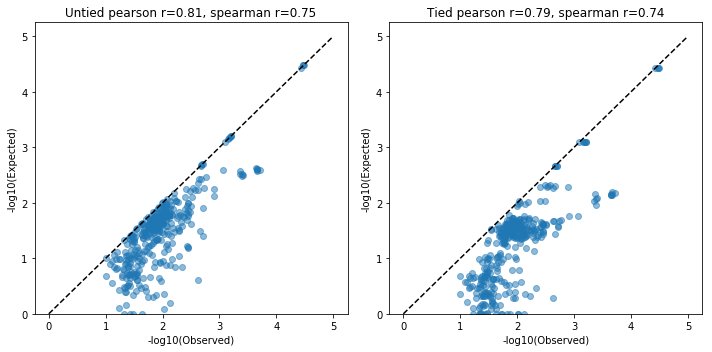

In [48]:
import scipy.stats.stats as stats

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

indices = observed_genome_wb != 0
pearsonr = stats.pearsonr(np.log10(observed_genome_wb[indices]), np.clip(np.log10(expected_genome_wb[indices]), 0, None))[0]
spearmanr = stats.spearmanr(np.log10(observed_genome_wb[indices]), np.clip(np.log10(expected_genome_wb[indices]), 0, None))[0]
plt.title('Untied pearson r=%0.2f, spearman r=%0.2f' % (pearsonr, spearmanr))

plt.scatter(np.log10(observed_genome_wb[indices]), np.clip(np.log10(expected_genome_wb[indices]), 0, None), alpha=0.5)
        
max_value = np.ceil(np.max(np.log10(observed_genome_wb)))
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
plt.xlabel('-log10(Observed)')
plt.ylabel('-log10(Expected)')
plt.ylim([0, None])

plt.subplot(1, 2, 2)

indices = observed_genome_wb_tied != 0
pearsonr = stats.pearsonr(np.log10(observed_genome_wb_tied[indices]), np.clip(np.log10(expected_genome_wb_tied[indices]), 0, None))[0]
spearmanr = stats.spearmanr(np.log10(observed_genome_wb_tied[indices]), np.clip(np.log10(expected_genome_wb_tied[indices]), 0, None))[0]
plt.title('Tied pearson r=%0.2f, spearman r=%0.2f' % (pearsonr, spearmanr))

plt.scatter(np.log10(observed_genome_wb_tied[indices]), np.clip(np.log10(expected_genome_wb_tied[indices]), 0, None), alpha=0.5)
        
max_value = np.ceil(np.max(np.log10(observed_genome_wb_tied)))
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
plt.xlabel('-log10(Observed)')
plt.ylabel('-log10(Expected)')
plt.ylim([0, None])


plt.tight_layout()
plt.show()

In [49]:
error_types = [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3)]
error_type_to_index = dict([(x, i) for i, x in enumerate(error_types)])

errors_genome_wb = np.zeros((len(error_types), m))
errors_genome_lcl = np.zeros((len(error_types), m))
errors_genome_wb_tied = np.zeros((len(error_types), m))
errors_genome_lcl_tied = np.zeros((len(error_types), m))


# Genome WB
for trans, n in zip(all_transitions, n_genome_wb):
    if len(trans) == 1:
        for t in trans:
            errors_genome_wb[error_type_to_index[tuple(t[1:])], t[0]] += n

for trans, n in zip(all_transitions, n_genome_wb_tied):
    if len(trans) == 1:
        for t in trans:
            errors_genome_wb_tied[error_type_to_index[tuple(t[1:])], t[0]] += n
            
# Genome LCL
for trans, n in zip(all_transitions, n_genome_lcl):
    if len(trans) == 1:
        for t in trans:
            errors_genome_lcl[error_type_to_index[tuple(t[1:])], t[0]] += n

for trans, n in zip(all_transitions, n_genome_lcl_tied):
    if len(trans) == 1:
        for t in trans:
            errors_genome_lcl_tied[error_type_to_index[tuple(t[1:])], t[0]] += n


In [50]:
f = np.sum(observed_genome_wb-expected_genome_wb)/np.sum(observed_genome_wb)
print('Fraction unexplained non-mendelian (untied)', f)
print(np.sum(observed_genome_wb-expected_genome_wb))

f = np.sum(observed_genome_wb_tied-expected_genome_wb_tied)/np.sum(observed_genome_wb_tied)
print('\nFraction unexplained non-mendelian (tied)', f)
print(np.sum(observed_genome_wb_tied-expected_genome_wb_tied))

Fraction unexplained non-mendelian (untied) 0.28444398023
57770.0034967

Fraction unexplained non-mendelian (tied) 0.37881020483
76935.5949806


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


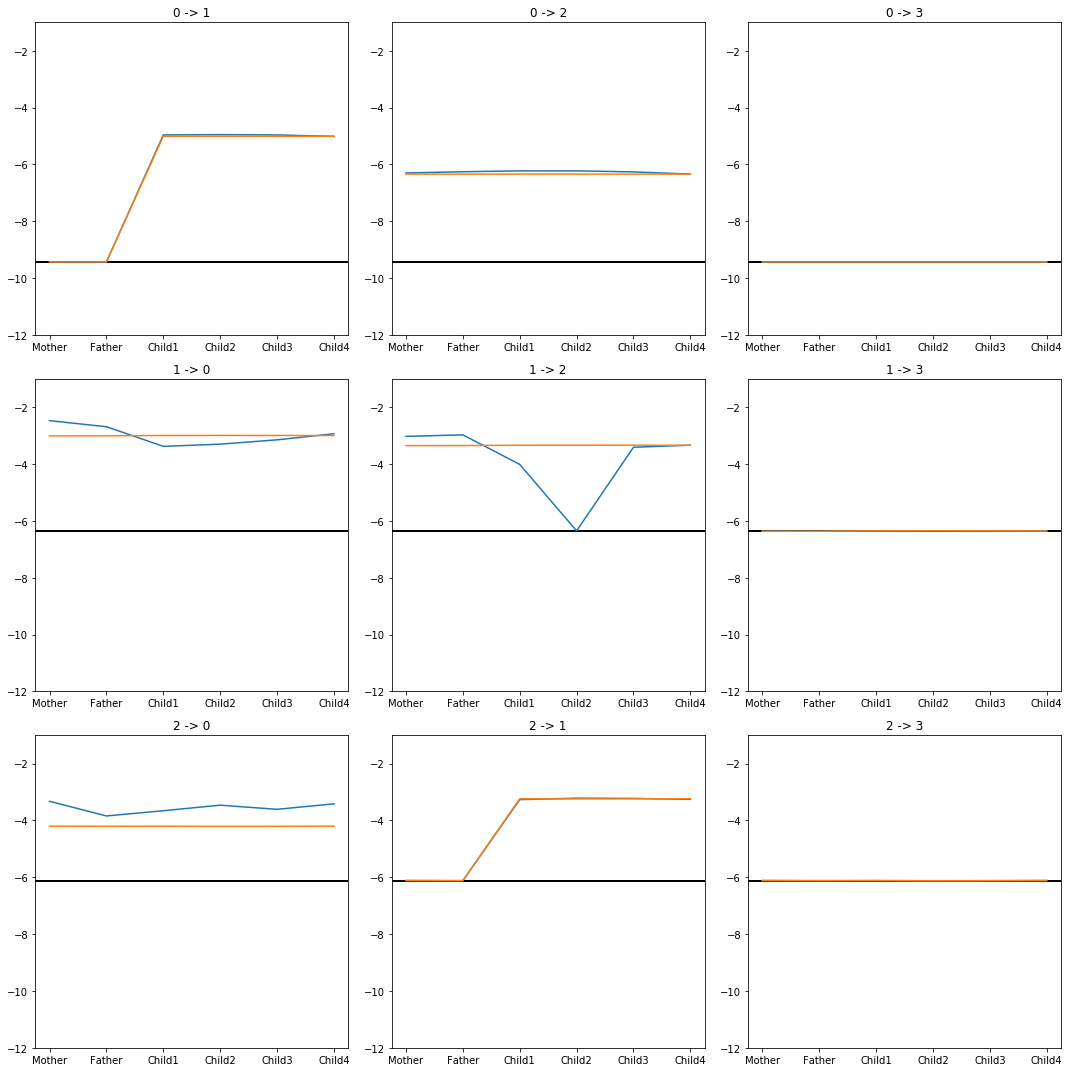

In [51]:
plt.figure(figsize=(15, 15))

cost = np.zeros((len(error_types),), dtype=float)

for i, (f, t) in enumerate(error_types):
    plt.subplot(3, 3, i+1)
    
    errors = errors_genome_wb[i, :]
    errors_tied = errors_genome_wb_tied[i, :]
    
    norm_factors = np.zeros((m,))
    for j in range(m):
        norm_factors[j] = np.sum((genotype_to_counts_genome*is_mendelian)[tuple(f if k==j else slice(None, None, None) for k in range(m))])
        plt.axhline(-np.log10(norm_factors[j]), color='black')
    
    
    plt.plot(np.clip(np.log10(errors), 0, None)-np.log10(norm_factors))
    plt.plot(np.clip(np.log10(errors_tied), 0, None)-np.log10(norm_factors))
    cost[i] = -(np.clip(np.log10(errors_tied[-1]), 0, None)-np.log10(norm_factors[-1]))
        
    plt.title('%d -> %d' % (f, t))
    plt.xticks(range(m), ['Mother', 'Father'] + ['Child%d' % i for i in range(1, m-1)])
    plt.ylim([-12, -1])

plt.tight_layout()            
plt.show()



In [55]:
baseline = np.ones((3,))
for e, c in zip(error_types, cost):
    print(e, c)
    baseline[e[0]] -= pow(10, -c)

for i, b in enumerate(baseline):
    print(i, -np.log10(b))

(0, 1) 5.00625120524
(0, 2) 6.33863966953
(0, 3) 9.42875043692
(1, 0) 2.99660510341
(1, 2) 3.34033261697
(1, 3) 6.35456094571
(2, 0) 4.2009022618
(2, 1) 3.23426306141
(2, 3) 6.11421019438
0 4.48019908671e-06
1 0.000636720069454
2 0.000281003570787


# Estimate double deletion rate

In [56]:
chrom = 'Y'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_callsY = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = 0

# remove positions where whole family is missing or whole family is homref
#ok_indices = np.any(A>0, axis=0)
#A = A[:, ok_indices]
#snp_positions = snp_positions[ok_indices]

print(A.shape)
genY = A
positionsY = snp_positions

['chr.Y.gen.npz']
(4610, 231075)


In [57]:
# skip PAR
start, end = 2649520, 59034050
ok_indices = (positionsY>start) & (positionsY<end)
genY = genY[:, ok_indices]
positionsY = positionsY[ok_indices]
num_callsY = positionsY.shape[0]

print(genY.shape)

(4610, 231075)


In [58]:
female_indices = [sample_id in sample_id_to_sex and sample_id_to_sex[sample_id]=='2' for sample_id in sample_ids]
print(np.sum(female_indices), len(female_indices))

1514 4610


In [59]:
g, c = np.unique(genY[female_indices, :], return_counts=True)
print(g, c)
print('-1 -> -1', c[-1]/np.sum(c), np.log10(c[-1]/np.sum(c)))
print('-1 -> 0', c[0]/np.sum(c), np.log10(c[0]/np.sum(c)))
print('-1 -> 1', c[1]/np.sum(c), np.log10(c[1]/np.sum(c)))
print('-1 -> 2', c[2]/np.sum(c), np.log10(c[2]/np.sum(c)))

[0 1 2] [328461393  10724778  10661379]
-1 -> -1 0.0304743566162 -1.51606545457
-1 -> 0 0.938870067834 -0.027394506485
-1 -> 1 0.03065557555 -1.5134905257
-1 -> 2 0.0304743566162 -1.51606545457


# Estimate single deletion error rate

In [60]:
mother_son_pairs = []
for fkey, inds in families.items():
    for child in inds[2:]:
        if sample_id_to_sex[child] == '1':
            mother_son_pairs.append((inds[0], child))

print(len(mother_son_pairs))

1640


In [62]:
chrom = 'X'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_callsX = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = 0

# remove positions where whole family is missing or whole family is homref
#ok_indices = np.any(A>0, axis=0)
#A = A[:, ok_indices]
#snp_positions = snp_positions[ok_indices]

print(A.shape)
genX = A
positionsX = snp_positions

['chr.X.0.gen.npz', 'chr.X.1.gen.npz']
(4610, 2965581)


In [63]:
print(genX.shape)

(4610, 2965581)


In [64]:
# skip PAR

start, end = 2699520, 154931044
start_index, end_index = None, None
for i, x in enumerate(positionsX):
    if x>start:
        start_index = i
        break

for i, x in enumerate(reversed(positionsX)):
    if x < end:
        end_index = positionsX.shape[0] - 1 - i
        break
        
print(start_index, end_index, positionsX[start_index], positionsX[end_index])
genX = genX[:, start_index:(end_index+1)]
positionsX = positionsX[start_index:(end_index+1)]
num_callsX = positionsX.shape[0]

print(genX.shape)

95116 2955906 2699522 154930651
(4610, 2860791)


In [65]:
counts = np.zeros((4, 4), dtype=int)
#for mother, son in mother_son_pairs:
moson_to_counts = defaultdict(int)

for _ in range(20):
    mother, son = random.choice(mother_son_pairs)
    print(mother, son)
    mother_index, son_index = sample_id_to_index[mother], sample_id_to_index[son]
    g, c = np.unique(genX[[mother_index, son_index], :], axis=1, return_counts=True)
    for x, y in zip(g.T, c):
        moson_to_counts[tuple(x)] += y

AU015001 AU015004
AU1042202 AU1042301
AU004801 AU004803
AU1187202 AU1187302
AU1042202 AU1042302
AU1885202 AU1885301
AU1816202 AU1816303
AU2265202 AU2265302
AU1078202 AU1078302
AU1725202 AU1725306
AU1983202 AU1983303
AU1890202 AU1890302
AU2007202 AU2007301
AU1802202 AU1802302
AU3724202 AU3724302
AU084501 AU084503
AU1266202 AU1266302
AU1648202 AU1648302
AU1009202 AU1009302
AU2352202 AU2352303


In [66]:
mgen = 0
print('Mother %d' % mgen)
norm_factor = np.sum([moson_to_counts[(mgen, i)] for i in range(4)])
print('0', moson_to_counts[(mgen, 0)]/norm_factor, np.log10(moson_to_counts[(mgen, 0)]/norm_factor))
print('1', moson_to_counts[(mgen, 1)]/norm_factor, np.log10(moson_to_counts[(mgen, 1)]/norm_factor))
print('2', moson_to_counts[(mgen, 2)]/norm_factor, np.log10(moson_to_counts[(mgen, 2)]/norm_factor))
print('3', moson_to_counts[(mgen, 3)]/norm_factor, np.log10(moson_to_counts[(mgen, 3)]/norm_factor))

mgen = 1
print('Mother %d' % mgen)
norm_factor = np.sum([moson_to_counts[(mgen, i)] for i in range(4)])
print('0', moson_to_counts[(mgen, 0)]/norm_factor, np.log10(moson_to_counts[(mgen, 0)]/norm_factor))
print('1', moson_to_counts[(mgen, 1)]/norm_factor, np.log10(moson_to_counts[(mgen, 1)]/norm_factor))
print('2', moson_to_counts[(mgen, 2)]/norm_factor, np.log10(moson_to_counts[(mgen, 2)]/norm_factor))
print('3', moson_to_counts[(mgen, 3)]/norm_factor, np.log10(moson_to_counts[(mgen, 3)]/norm_factor))

mgen = 2
print('Mother %d' % mgen)
norm_factor = np.sum([moson_to_counts[(mgen, i)] for i in range(4)])
print('0', moson_to_counts[(mgen, 0)]/norm_factor, np.log10(moson_to_counts[(mgen, 0)]/norm_factor))
print('1', moson_to_counts[(mgen, 1)]/norm_factor, np.log10(moson_to_counts[(mgen, 1)]/norm_factor))
print('2', moson_to_counts[(mgen, 2)]/norm_factor, np.log10(moson_to_counts[(mgen, 2)]/norm_factor))
print('3', moson_to_counts[(mgen, 3)]/norm_factor, np.log10(moson_to_counts[(mgen, 3)]/norm_factor))

mgen = 3
print('Mother %d' % mgen)
norm_factor = np.sum([moson_to_counts[(mgen, i)] for i in range(4)])
print('0', moson_to_counts[(mgen, 0)]/norm_factor, np.log10(moson_to_counts[(mgen, 0)]/norm_factor))
print('1', moson_to_counts[(mgen, 1)]/norm_factor, np.log10(moson_to_counts[(mgen, 1)]/norm_factor))
print('2', moson_to_counts[(mgen, 2)]/norm_factor, np.log10(moson_to_counts[(mgen, 2)]/norm_factor))
print('3', moson_to_counts[(mgen, 3)]/norm_factor, np.log10(moson_to_counts[(mgen, 3)]/norm_factor))


Mother 0
0 0.998725713931 -0.000553768312623
1 0.00118509168453 -2.92624804919
2 8.91943842037e-05 -4.04966248852
3 0.0 -inf
Mother 1
0 0.498835377736 -0.302042753649
1 0.031483915527 -1.50191126151
2 0.469680706737 -0.328197279139
3 0.0 -inf
Mother 2
0 0.00747595098582 -2.12633355463
1 0.00290234382456 -2.53725114039
2 0.98962170519 -0.00453078797402
3 0.0 -inf
Mother 3
0 nan nan
1 nan nan
2 nan nan
3 nan nan


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


# Estimate crossover rate

In [102]:
# estimate probability of recombination
print('Crossovers per child', (1+1.7)*22.8)
print('Maternal crossover log10(P)', np.log10(22.8)-np.log10(sum(chrom_lengths.values())))
print('Paternal crossover log10(P)', np.log10(1.7*22.8)-np.log10(sum(chrom_lengths.values())))
print('Overall crossover log10(P)', np.log10((1+1.7)*22.8)-np.log10(sum(chrom_lengths.values())))

Crossovers per child 61.56000000000001
Maternal crossover log10(P) -8.09900216768
Paternal crossover log10(P) -7.8685532463
Overall crossover log10(P) -7.66763840352


In [119]:
print('Total independent errors', m*sum(errors_genome_wb_tied[:, -1]))
print('Overall error rate', np.log10(m*sum(errors_genome_wb_tied[:, -1])) - np.log10(sum(chrom_lengths.values())))
print('Average cost per bp', m*sum(errors_genome_wb_tied[:, -1] * cost)/sum(chrom_lengths.values()))

Total independent errors 349227.907886
Overall error rate -3.91382807244
Average cost per bp 0.00118994027401


In [115]:
print(cost)

[10 14 10  6  7  8 11  6  8]


In [235]:
print('Deletion transition', np.log10(2)-np.log10(sum(chrom_lengths.values())))
print('Hard to sequence region transition', np.log10(2000)-np.log10(sum(chrom_lengths.values())))

Deletion transition -9.15590701902
Hard to sequence region transition -6.15590701902


# Estimate emmision probabilities in hard-to-sequence regions

In [226]:
del_mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1), (0, 1, 2),
    (0, 2, 1), (0, 2, 0), (0, 2, 2),
    (1, 0, 0), (1, 0, 1), (1, 0, 2),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2), (1, 2, 0),
    (2, 0, 1), (2, 0, 0), (2, 0, 2),
    (2, 1, 1), (2, 1, 2), (2, 1, 0),
    (2, 2, 2)
}
is_del_mendelian = np.ones(tuple(len(x) for x in possible_genotypes_famgen), dtype=bool)
for famgen in all_famgens:
    is_del_mend = True
    for j in range(2, m):
        if tuple([famgen[x] for x in [0, 1, j]]) not in del_mendelian_trios:
            is_del_mend = False
    is_del_mendelian[famgen] = is_del_mend
print('Del Mendelian', np.sum(is_del_mendelian))
print(is_del_mendelian.shape)


Del Mendelian 569
(4, 4, 4, 4, 4, 4)


In [229]:
two_plus_steps = []
del_nonmendelian_famgens = list(zip(*np.where(~is_del_mendelian)))
del_mendelian_famgens = list(zip(*np.where(is_del_mendelian)))
for nm in del_nonmendelian_famgens:
    has_neighbor = False
    for m in del_mendelian_famgens:
        diff = len([_ for x, y in zip(nm, m) if x!=y])
        if diff == 1:
            has_neighbor = True
    if not has_neighbor:
        two_plus_steps.append(nm)

In [230]:
print(len(two_plus_steps))

2117


In [231]:
print([x for x in two_plus_steps if 3 not in x])

[]


In [232]:
emissions = [0]*4
for nm in two_plus_steps:
    for g in nm:
        emissions[g] += genotype_to_counts_genome[nm]

In [233]:
print(np.log10(emissions/np.sum(emissions)))

[-0.41768609 -1.83750238 -1.78115939 -0.23159119]


In [237]:
print(np.log10(3))

0.47712125472


In [240]:
print('0->0', np.log10(1 - pow(10, -5.06355804022) - pow(10, -4.94146261578) - pow(10, -7.02354087895)))
print('1->1', np.log10(1 - pow(10, -4.17651249194) - pow(10, -2.98674026891,) - pow(10, -3.50427197273)))
print('2->2', np.log10(1 - pow(10, -4.15130603735) - pow(10, -5.60258127541,) - pow(10, -3.19542864628)))





0->0 -8.76251358641e-06
1->1 -0.000613107855169
2->2 -0.000308768398653


In [243]:
# in a hard to sequence region, errors are 10x more likely
a = np.asarray([[0, -1, -2], [-3, -4, -5]], dtype=float)
print(np.power(2, a))

[[ 1.       0.5      0.25   ]
 [ 0.125    0.0625   0.03125]]


# Estimate missing value rate


In [24]:
chrom = '14'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_callsX = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A==-1] = 3
A[A==-2] = 4

# remove positions where whole family is missing or whole family is homref
#ok_indices = np.any(A>0, axis=0)
#A = A[:, ok_indices]
#snp_positions = snp_positions[ok_indices]

print(A.shape)
gen14 = A
positions14 = snp_positions

['chr.14.0.gen.npz', 'chr.14.1.gen.npz']
(4610, 2344178)


In [13]:
is_female = np.asarray([False if x not in sample_id_to_sex else sample_id_to_sex[x]=='2' for x in sample_ids], dtype=bool)
is_male = np.asarray([False if x not in sample_id_to_sex else sample_id_to_sex[x]=='1' for x in sample_ids], dtype=bool)

mother_indices = [sample_id_to_index[inds[0]] for inds in families.values()]
father_indices = [sample_id_to_index[inds[1]] for inds in families.values()]
print('mothers', len(mother_indices), 'fathers', len(father_indices))

affected_male_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='1' and sample_id_to_affected[x]=='2'] for inds in families.values()], [])
affected_female_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='2' and sample_id_to_affected[x]=='2'] for inds in families.values()], [])
unaffected_male_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='1' and sample_id_to_affected[x]=='1'] for inds in families.values()], [])
unaffected_female_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='2' and sample_id_to_affected[x]=='1'] for inds in families.values()], [])
print('aff-M', len(affected_male_indices), 'aff-F', len(affected_female_indices),
     'unaff-M', len(unaffected_male_indices), 'unaff-F', len(unaffected_female_indices))


mothers 886 fathers 886
aff-M 1436 aff-F 421 unaff-M 204 unaff-F 215


In [25]:
num3s = np.sum(gen14==3, axis=1)
num4s = np.sum(gen14==4, axis=1)

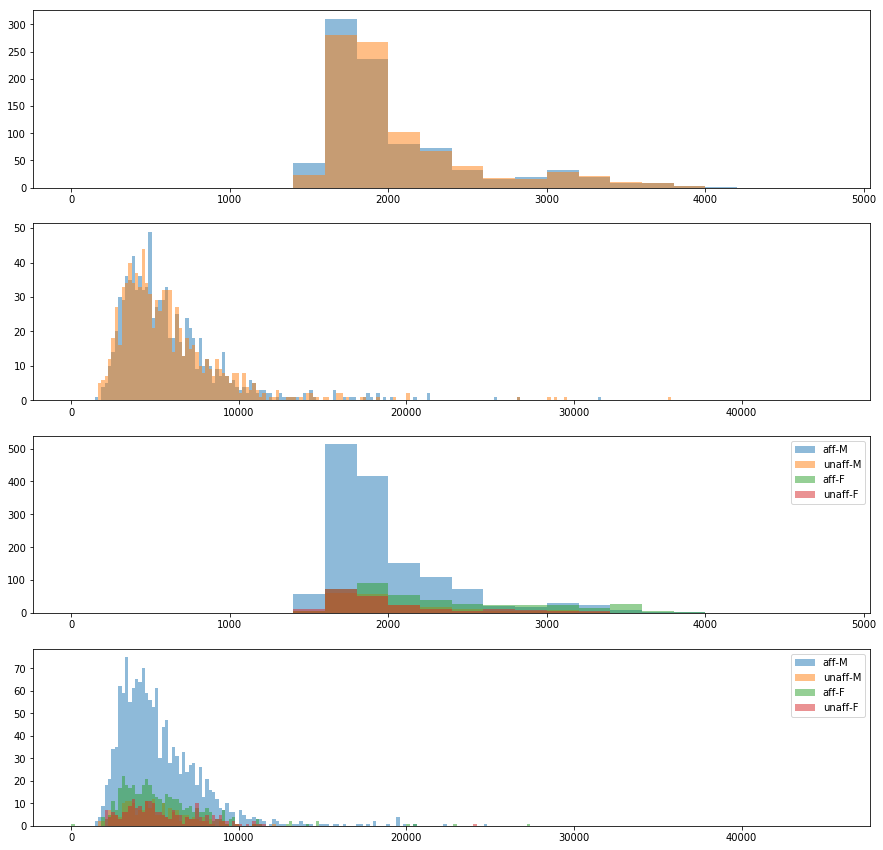

In [26]:
plt.figure(figsize=(15, 15))

min_value, max_value = min(np.min(num3s), np.min(num4s)), max(np.max(num3s), np.max(num4s))

plt.subplot(4, 1, 1)
plt.hist(num3s[mother_indices], alpha=0.5, bins=range(min_value, 5000, 200))
plt.hist(num3s[father_indices], alpha=0.5, bins=range(min_value, 5000, 200))

plt.subplot(4, 1, 2)
plt.hist(num4s[mother_indices], alpha=0.5, bins=range(min_value, max_value, 200))
plt.hist(num4s[father_indices], alpha=0.5, bins=range(min_value, max_value, 200))

plt.subplot(4, 1, 3)
plt.hist(num3s[affected_male_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='aff-M')
plt.hist(num3s[unaffected_male_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='unaff-M')
plt.hist(num3s[affected_female_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='aff-F')
plt.hist(num3s[unaffected_female_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='unaff-F')
plt.legend()

plt.subplot(4, 1, 4)
plt.hist(num4s[affected_male_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='aff-M')
plt.hist(num4s[unaffected_male_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='unaff-M')
plt.hist(num4s[affected_female_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='aff-F')
plt.hist(num4s[unaffected_female_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='unaff-F')
plt.legend()

plt.show()

In [31]:
from scipy import stats

print(stats.ttest_ind(num3s[mother_indices], num3s[father_indices], equal_var=False))
print(stats.ttest_ind(num4s[mother_indices], num4s[father_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_male_indices], num3s[unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_male_indices], num4s[unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices], num3s[unaffected_female_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices], num4s[unaffected_female_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+unaffected_female_indices], num3s[affected_male_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+unaffected_female_indices], num4s[affected_male_indices+unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+affected_male_indices], num3s[unaffected_female_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+affected_male_indices], num4s[unaffected_female_indices+unaffected_male_indices], equal_var=False))

print()
print('aff-M', np.median(num3s[affected_male_indices]), 'unaff-M', np.median(num3s[unaffected_male_indices]))
print('aff-F', np.median(num3s[affected_female_indices]), 'unaff-F', np.median(num3s[unaffected_female_indices]))
print()
print('aff-M', np.median(num4s[affected_male_indices]), 'unaff-M', np.median(num4s[unaffected_male_indices]))
print('aff-F', np.median(num4s[affected_female_indices]), 'unaff-F', np.median(num4s[unaffected_female_indices]))


Ttest_indResult(statistic=-0.89827744697050471, pvalue=0.36915993370520139)
Ttest_indResult(statistic=0.14291110553540098, pvalue=0.88637685831104429)

Ttest_indResult(statistic=-1.955328452264431, pvalue=0.051625497748633606)
Ttest_indResult(statistic=2.2421915351438124, pvalue=0.025618154040384797)

Ttest_indResult(statistic=6.8650845578481903, pvalue=1.8130442087825161e-11)
Ttest_indResult(statistic=-0.26584925841510182, pvalue=0.7904718196092394)

Ttest_indResult(statistic=9.5637626311970187, pvalue=1.0879153063429461e-20)
Ttest_indResult(statistic=1.7089482857598335, pvalue=0.087744744027714955)

Ttest_indResult(statistic=0.92896459968122147, pvalue=0.35324770298598418)
Ttest_indResult(statistic=0.70165602859859888, pvalue=0.48312473325204885)

aff-M 1843.5 unaff-M 1908.0
aff-F 2116.0 unaff-F 1861.0

aff-M 4706.0 unaff-M 4729.5
aff-F 4835.0 unaff-F 4870.0


In [23]:
from scipy import stats

print(stats.ttest_ind(num3s[mother_indices], num3s[father_indices], equal_var=False))
print(stats.ttest_ind(num4s[mother_indices], num4s[father_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_male_indices], num3s[unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_male_indices], num4s[unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices], num3s[unaffected_female_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices], num4s[unaffected_female_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+unaffected_female_indices], num3s[affected_male_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+unaffected_female_indices], num4s[affected_male_indices+unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+affected_male_indices], num3s[unaffected_female_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+affected_male_indices], num4s[unaffected_female_indices+unaffected_male_indices], equal_var=False))



Ttest_indResult(statistic=0.23642638301894697, pvalue=0.81312919826491892)
Ttest_indResult(statistic=0.73492738906866617, pvalue=0.46248108305408464)

Ttest_indResult(statistic=-1.904865207219206, pvalue=0.057919843946557338)
Ttest_indResult(statistic=-0.69986605364756427, pvalue=0.48463154372046391)

Ttest_indResult(statistic=6.9437339464087344, pvalue=1.0512852666684551e-11)
Ttest_indResult(statistic=-0.13916502274488166, pvalue=0.88938402168454922)

Ttest_indResult(statistic=10.268752730879319, pvalue=1.9833088057499401e-23)
Ttest_indResult(statistic=0.71876574324927622, pvalue=0.47242864458482492)

Ttest_indResult(statistic=0.78864365573673822, pvalue=0.43059944987485477)
Ttest_indResult(statistic=-0.78004821937352609, pvalue=0.43565933201123463)


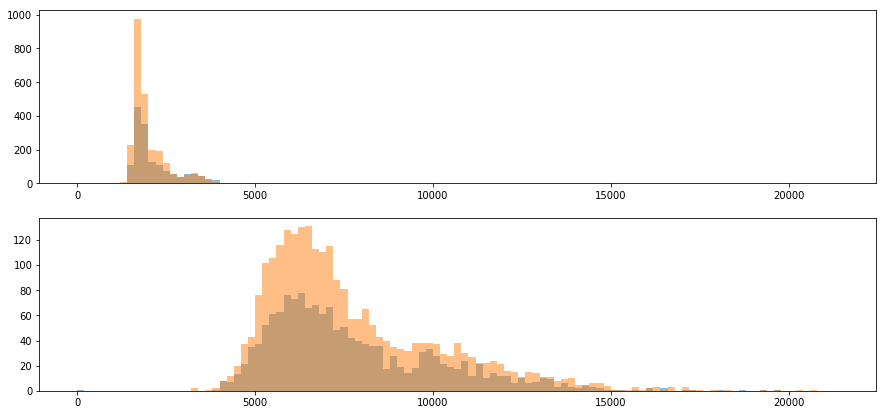

In [252]:
plt.figure(figsize=(15, 7))

min_value, max_value = min(np.min(num3s), np.min(num4s)), max(np.max(num3s), np.max(num4s))

plt.subplot(2, 1, 1)
plt.hist(num3s[is_female], alpha=0.5, bins=range(min_value, max_value, 200))
plt.hist(num3s[is_male], alpha=0.5, bins=range(min_value, max_value, 200))

plt.subplot(2, 1, 2)
plt.hist(num4s[is_female], alpha=0.5, bins=range(min_value, max_value, 200))
plt.hist(num4s[is_male], alpha=0.5, bins=range(min_value, max_value, 200))

plt.show()